<a href="https://colab.research.google.com/github/iupui-soic/pybootcamp/blob/main/Sameer_Chapter_4_training_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 4 – Training Models

1.Linear regression train 2 diiferent ways

* closed form eqaution,

* gradient descent( batch GD, mini-batch GD, stochastic GD).

2.polynomial regression - A more complex model that can fit nolinear datasets
since it has more parameters - overfitting the training data ,The regularisation techniques can reducing overfitting the training data

* Learning curves

* Ridge Regression ( Lasso Regression, Elastic Net Regression)

3.Logistic regression

4.softmax regression


# Setup

This project requires Python 3.7 or above:

In [242]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [243]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [244]:
#And let's create the `images/training_linear_models` folder (if it doesn't already exist),
#and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

from pathlib import Path
IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Linear Regression


linear model makes a **prediction** by simply computing a weighted
 sum of the input features, plus a constant called the **bias term** (also called the intercept term)

The most common performance measure of a regression model is the **root mean square error.**

Therefore, to  train a linear regression model, we need to find the value of **θ** that **minimizes the RMSE**. In practice, it is simpler to minimize the mean squared error **(MSE)** than the RMSE, and it leads to the **same result** (because the value that minimizes a positive function also minimizes its square root).

## The Normal Equation

 To find the value of **θ** that minimizes the MSE, there exists a **closed-form solution**—in other words, a mathematical equation that gives the **result directly**. This is called the Normal equation

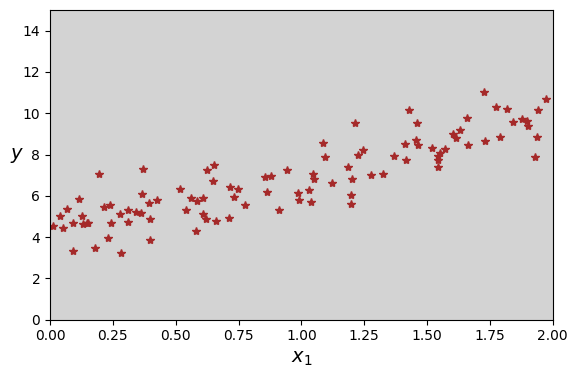

In [245]:
import numpy as np
#some linear-looking data to test equation
np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(X, y, "*", color="brown")
plt.gca().set_facecolor('lightgrey')
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid(False)
save_fig("generated_data_plot")
plt.show()

 The **inv()** function from
 NumPy’s linear algebra module (np.linalg) is to compute the inverse of a matrix, and
 the **dot()** method for matrix multiplication

In [246]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

The **@** operator performs **matrix multiplication**. If A and B are
 NumPy arrays, then A @ B is equivalent to np.matmul(A, B). Many
 other libraries, like **TensorFlow, PyTorch, and JAX,** support the @
 operator as well.



In [247]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for θ0
 = 4 and θ1
 = 3 instead of θ0
 = 4.215 and θ1
 = 2.770.
 Close enough, but the noise made it impossible to recover the exact parameters of the
 original function. The smaller and noisier the dataset, the harder it gets

In [248]:
#we can make predicions by uisng 0
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

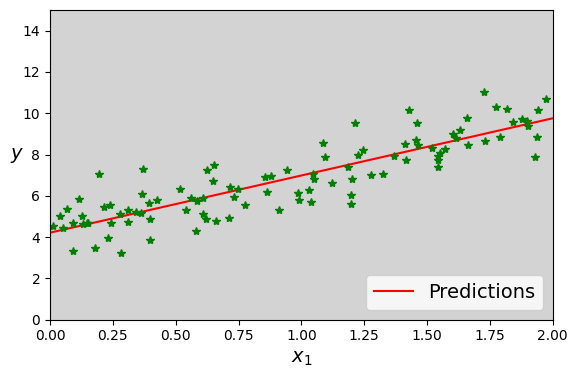

In [249]:
import matplotlib.pyplot as plt

#plotting model predictions
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "g*")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.gca().set_facecolor('lightgrey')
plt.axis([0, 2, 0, 15])
plt.grid(False)
plt.legend(loc="lower right")
save_fig("linear_model_predictions_plot")

plt.show()

 θ is the value of θ that minimizes the cost function.
 • y is the vector of target values containing y(1) to y(m).  x is the instance’s feature vector, containing x0
 to xn
 , with x0
 always equal to 1.

In [250]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [251]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares").

In [252]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [253]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

Now looking at a very different way to train a linear regression model, which is
 better suited for cases where there are are **large number of features or too many training
 instances** to fit in memory.

# Gradient Descent
Gradient descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of gradient descent is to **tweak
 parameters** iteratively in order to minimize a cost function.
## Batch Gradient Descent

This involves training set at each gradient descent step! This is why the algorithm is called **batch gradient descent:** it uses the whole batch of training data at **every step** (actually, full gradient descent would probably
be a better name).

Once you have the gradient vector, which points uphill, just go in the opposite
 direction to go downhill. This means subtracting ∇θ
 MSE(θ) from θ. This is where the
 learning rate **η** comes into play multiply the gradient vector by η to determine the size of the downhill step

In [254]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

The trained model parameters:

In [255]:
theta

array([[4.21509616],
       [2.77011339]])

That’s exactly what the Normal equation found! Gradient descent worked per
fectly.  using a different learning rate it shows
 the first 20 steps of gradient descent using three different learning rates. The line
 at the bottom of each plot represents the random starting point, then each epoch is
 represented by a darker and darker line


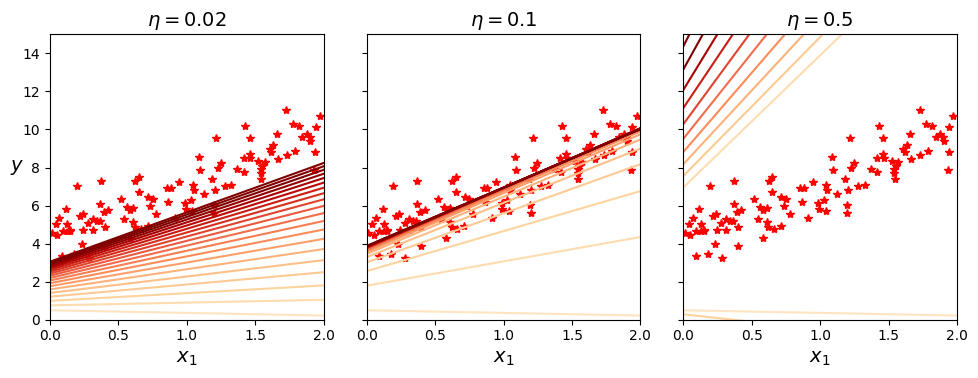

In [256]:
# extra code – generates and saves Figure 4–8

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "r*")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid(False)
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

 * On the left, the learning rate is too low: the algorithm will eventually reach the
 solution, but it will take a long time.

 * In the middle, the learning rate looks pretty
 good: in just a few epochs, it has already converged to the solution.

* On the right,
 the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.


epochs. If it is too low, it will still be far away from the optimal solution when the algorithm stops; but if it is too high, you will waste time while the model parameters do not change anymore.

A simple solution is to set a very large number of epochs but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number ϵ (called the tolerance)—because this happens when gradient descent has (almost) reached the minimum.

## Stochastic Gradient Descent

* The main problem with batch gradient descent is the fact that it uses the whole
 training set to compute the gradients at every step, which makes it very slow when
 the training set is **large**.

* At the opposite extreme, **stochastic gradient** descent picks a
 random instance in the training set at every step and computes the gradients based only on that single instance. Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at everyiteration.

* It also makes it possible to train on huge training sets,

 On the other hand, due to its **stochastic (i.e., random**) nature, this algorithm is much **less regular** than batch gradient descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down .

 When the cost function is very irregular, this can actually help the algorithm jump **out of local minima**, so stochastic gradient descent has a **better chance of finding the global minimum** than batch gradient descent does
 Once the
 algorithm stops, the final parameter **values will be good, but not optimal.**



One solution to this dilemma is to gradually **reduce the learning rate**. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the **global minimum.** This process is akin to **simulated annealing.**

In [257]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure

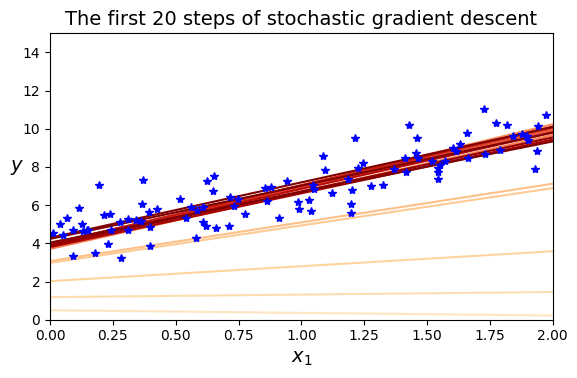

In [258]:
#This code implements stochastic gradient descent using a simple learning schedule
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))
for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b*")
plt.xlabel("$x_1$")
plt.title("The first 20 steps of stochastic gradient descent")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid(False)
save_fig("sgd_plot")
plt.show()

In [259]:
theta

array([[4.21076011],
       [2.74856079]])

In [260]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [261]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## Mini-batch gradient descent

 The last gradient descent algorithm we will look at is called mini-batch gradient
 descent.

 It is straightforward once you know batch and stochastic gradient descent:
 at each step, instead of computing the gradients based on the **full training** set (as in batch GD)  or based on **just one instance** (as in stochastic GD), mini-batch GD computes the gradients on **small random sets of instances called mini-batches**.

  

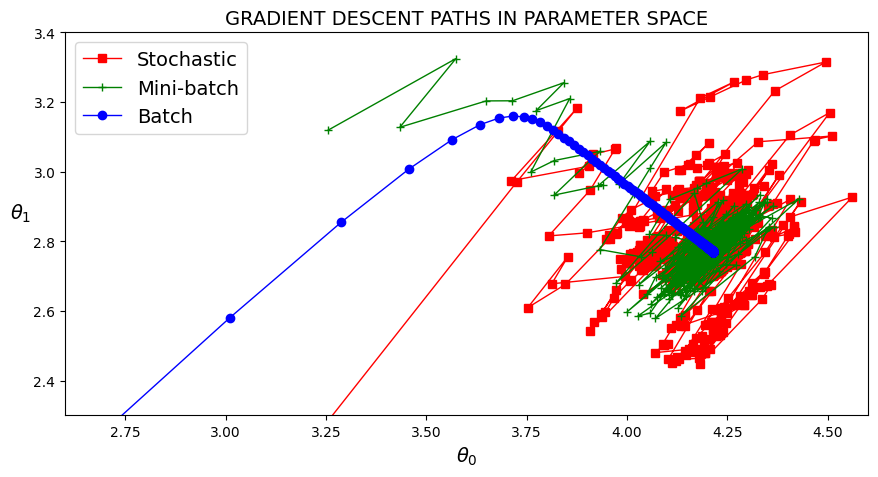

In [262]:
# extra code – this cell generates and saves Figure 4–11

from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(9, 5))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=1,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=1,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.title("GRADIENT DESCENT PATHS IN PARAMETER SPACE")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid(False)
save_fig("gradient_descent_paths_plot")
plt.show()

The provided plot visualizes the paths taken by different gradient descent algorithms to minimize a cost function.

The red line represents Stochastic Gradient Descent, which has a **highly erratic** path due to frequent updates.

The green line represents Mini-batch Gradient Descent, which shows **moderate variability.**

The blue line represents Batch Gradient Descent, which follows a **smooth and direct path** to the minimum.

The paths taken by the three gradient descent algorithms in parameter space
 during training. They all end up near the **minimum**, but batch GD’s path actually
**stops** at the minimum, while both stochastic GD and mini-batch GD continue to
 walk around. However,the batch GD takes a **lot of time** to take each
 step, and stochastic GD and mini-batch GD would also reach the minimum if
 used a good learning schedule.

# Polynomial Regression

If  data is more complex than a straight line? we can use a **linear model to fit nonlinear data**. A simple way to do this is to add **powers** of each feature as new features, then train a linear model on this extended set of features. This technique is called ***polynomial regression***.

In [263]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

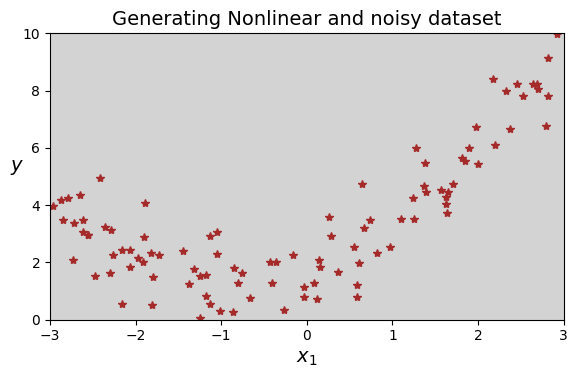

In [264]:
# extra code – this cell generates and saves Figure 4–12
plt.figure(figsize=(6, 4))
plt.plot(X, y, "*", color = "brown")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.title("Generating Nonlinear and noisy dataset")
plt.axis([-3, 3, 0, 10])
plt.grid(False)
plt.gca().set_facecolor('lightgrey')
save_fig("quadratic_data_plot")
plt.show()

In [265]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [266]:
X_poly[0]

array([-0.75275929,  0.56664654])

 X_poly now contains the original feature of X plus the square of this feature. Now we
 can fit a LinearRegression model to this extended training data

In [267]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

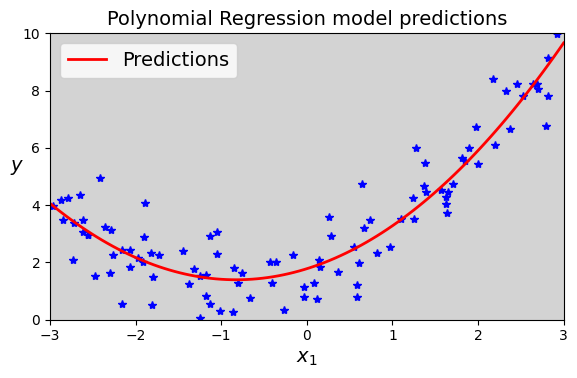

In [268]:
# extra code – this cell generates and saves Figure 4–13

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b*")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.title("Polynomial Regression model predictions")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.gca().set_facecolor('lightgrey')
plt.axis([-3, 3, 0, 10])
plt.grid(False)
save_fig("quadratic_predictions_plot")
plt.show()

# Learning Curves

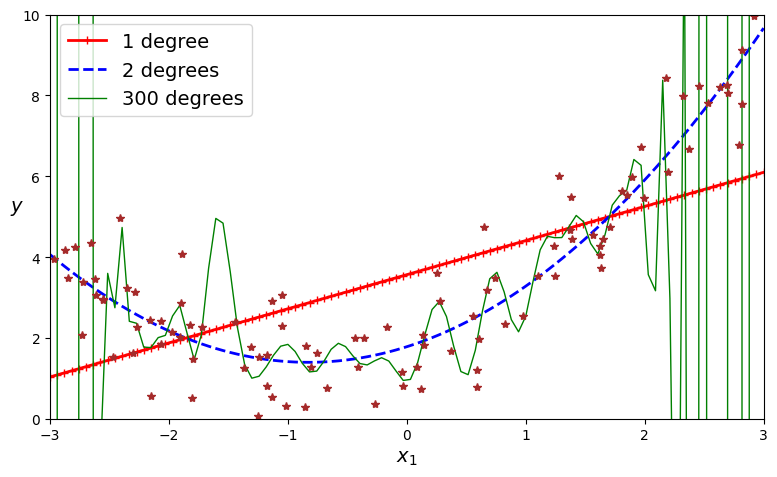

In [269]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(8, 5))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "*", color = "brown", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid(False)
save_fig("high_degree_polynomials_plot")
plt.show()

  This high-degree polynomial regression model is **severely overfitting the training** data, while the linear model is **underfitting** it. The model that will generalize **best** in this case is the **quadratic model**, which makes sense because the data was generated using a quadratic model.


 If a model performs well on the training data but generalizes poorly
 according to the cross-validation metrics, then your model is overfitting.
If it per forms poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex

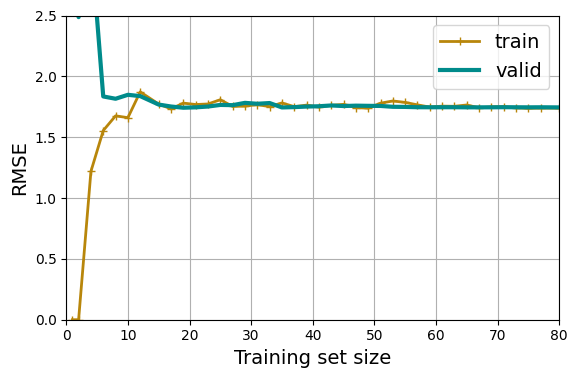

In [270]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "-+", color="#B8860B", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "-", color="#008B8B", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
save_fig("underfitting_learning_curves_plot")

plt.show()

The plot shows the Root Mean Square Error (RMSE) against the training set size for both training and validation datasets. The train RMSE, which decreases sharply initially and then stabilizes. The validation RMSE, which starts high, decreases rapidly, and then flattens out. This indicates that the model's performance improves with more training data until it reaches a point where additional data provides diminishing returns in reducing the RMSE.

In [271]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

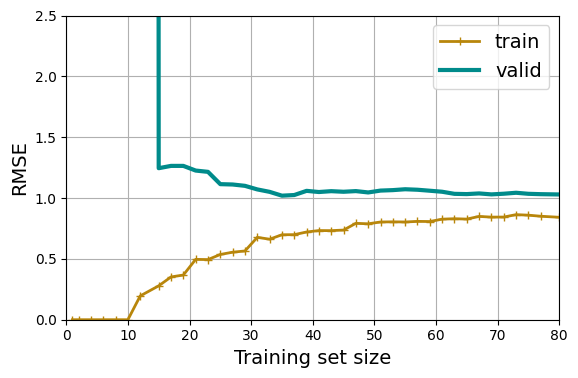

In [272]:
#looking at the learning curves of a 10th-degree polynomial model on the same data
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "-+", color="#B8860B", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "-", color="#008B8B", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
save_fig("learning_curves_plot")
plt.show()

These learning curves look a bit like the previous ones, but there are two very
 important differences:

 * The error on the training data is **much lower** than before.
 * There is a gap between the curves. This means that the model performs signif
icantly better on the training data than on the validation data, which is the  hallmark of an **overfitting model**. If you used a much larger training set, however,the two curves would continue to get closer.

# Regularized Linear Models

## Ridge Regression
 Ridge regression (also called Tikhonov regularization) is a regularized version of linear regression

Let's generate a very small and noisy linear dataset:

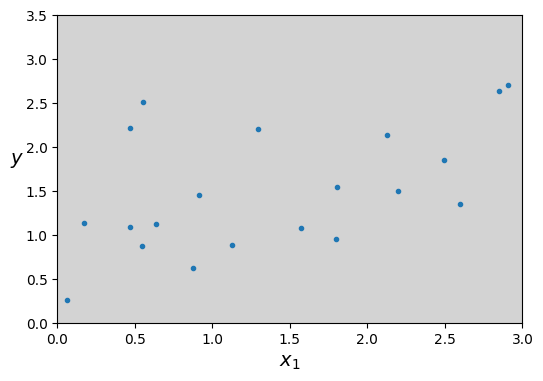

In [273]:
# extra code – we've done this type of generation several times before
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.gca().set_facecolor('lightgrey')
plt.axis([0, 3, 0, 3.5])
plt.grid(False)
plt.show()

In [274]:
#ridge regression using closed form solution by Andre louis cholesky

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

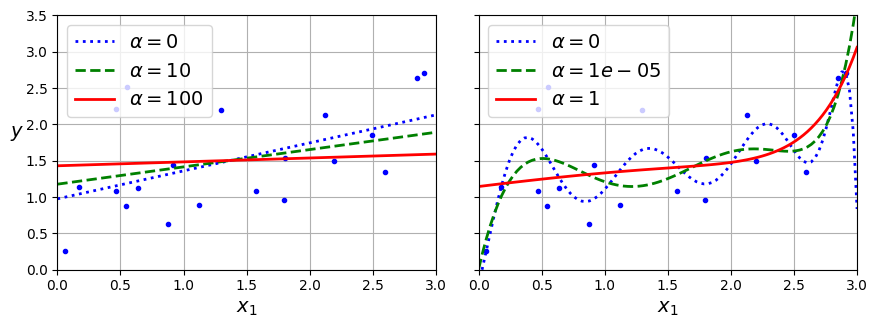

In [275]:
# extra code – this cell generates and saves Figure 4–17

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("ridge_regression_plot")
plt.show()

It shows several ridge models that were trained on some very noisy
 linear data using different α values.

 On the left, plain ridge models are used,
 leading to **linear predictions**.

  On the right, the data is first expanded using PolynomialFeatures(degree=10), then it is scaled using a StandardScaler, and
 finally the ridge models are applied to the resulting features: this is polynomial regression with ridge regularization. Note how increasing α leads to flatter (i.e.,**less extreme, more reasonable)** predictions, thus reducing the model’s variance but increasing its bias.

In [276]:
#using stochastic gradient descent

sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([1.55302613])

In [277]:
# extra code – show that we get roughly the same solution as earlier when
#              we use Stochastic Average GD (solver="sag")
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55326019]])

In [278]:
# extra code – shows the closed form solution of Ridge regression,
#              compare with the next Ridge model's learned parameters below
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

In [279]:
ridge_reg.intercept_, ridge_reg.coef_  # extra code

(array([0.97896386]), array([[0.38286422]]))

The code demonstrates three approaches to Ridge regression. First, it uses `SGDRegressor` with L2 penalty to perform ridge regression via stochastic gradient descent, predicting a value of approximately 1.553. Second, it employs the `Ridge` class with the "sag" solver, predicting a similar value of 1.553. Third, it shows the closed-form solution of Ridge regression using linear algebra, yielding parameters consistent with the `Ridge` model's learned parameters.

## Lasso Regression

 Least absolute shrinkage and selection operator regression (usually simply called lasso regression) is another regularized version of linear regression: just like ridge regression, it adds a **regularization term to the cost function**

In [280]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

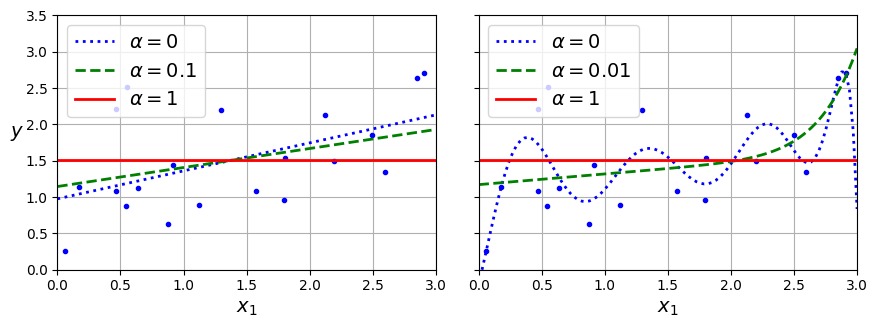

In [281]:
# extra code – this cell generates and saves Figure 4–18
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("lasso_regression_plot")
plt.show()

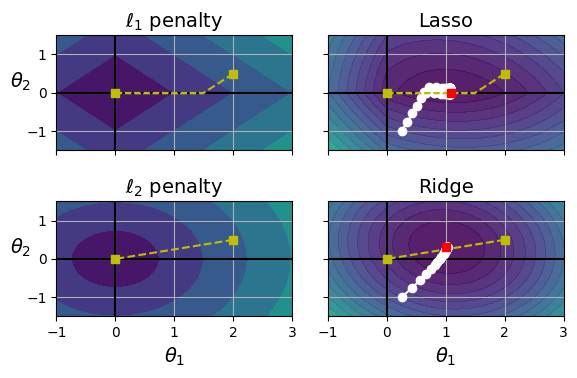

In [282]:
# extra code – this BIG cell generates and saves Figure 4–19

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 4))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

save_fig("lasso_vs_ridge_plot")
plt.show()

The plots compare the optimization paths for different regularization techniques in linear regression.

 The top left shows L1 penalty (Lasso) leading to **sparse solutions**(meaning some coefficients are exactly zero, which can simplify the model by feature selection) where some coefficients are exactly **zero**.

 The top right shows the **Lasso's optimization path** demonstrating similar sparsity.Shows how the coefficients change, highlighting the tendency of Lasso to push some coefficients to zero

 The bottom left shows L2 penalty (Ridge) leading to **non-sparse solutions** with smaller coefficients.Leads to non-sparse solutions where coefficients are reduced but not set to zero, helping to prevent overfitting.

 The bottom right demonstrates **Ridge regression's optimization path**, which results in more gradual coefficient adjustments without setting them to zero.Coefficients are adjusted more gradually compared to Lasso, without being set to zero, which stabilizes the model by shrinking coefficients.

## Elastic Net

 Elastic net regression is a middle ground between ridge regression and lasso regression. The regularization term is a weighted sum of both ridge and lasso’s regularization terms.

In [283]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

Let's go back to the quadratic dataset we used earlier:

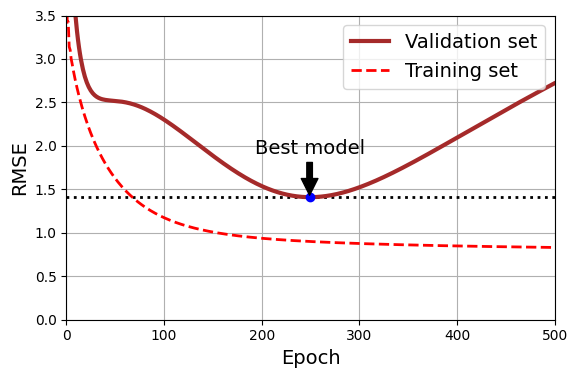

In [284]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "-", color= "brown", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
save_fig("early_stopping_plot")
plt.show()

 A very different way to regularize iterative learning algorithms such as gradient descent is to **stop training** as soon as the validation error **reaches a minimum**. This is called **early stopping.**

  It shows a complex model (in this case, a **high-degree**
  polynomial regression model) being trained with **batch gradient descent** on the **quadratic dataset** . As the  **epochs go** by, the algorithm learns, and its prediction error (RMSE) on the training set goes **down**, along with its prediction error on the validation set.
  
  After a while, though, the validation error **stops decreasing** and starts to go **back up**. This indicates that the model has **started to overfit** the training data.
  
  With early stopping just stop training as soon as the validation error reaches the **minimum**. It is such a **simple and efficient regularization** technique that **Geoffrey Hinton** called it a **beautiful free lunch**

# Logistic Regression

## Estimating Probabilities

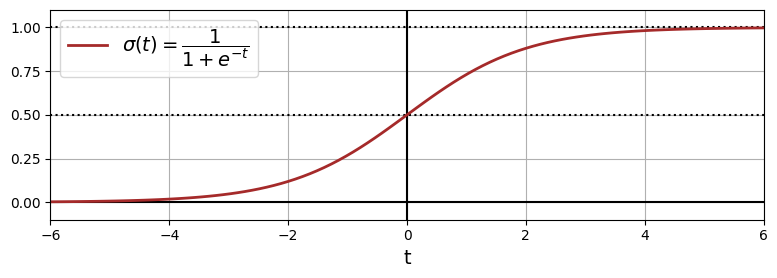

In [285]:
# extra code – generates and saves Figure 4–21

lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "-", color="brown", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
save_fig("logistic_function_plot")
plt.show()

The graph shows the logistic function, which maps input \(t\) to a probability between 0 and 1, demonstrating the **sigmoid shape** that transitions **smoothly** from 0 to 1 around \(t = 0\). This function is fundamental in logistic regression for binary classification, converting linear combinations of features into probabilities.

## Decision Boundaries

In [286]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [287]:
print(iris.DESCR)  # extra code – it's a bit too long

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [288]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [289]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int64

In [290]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [291]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

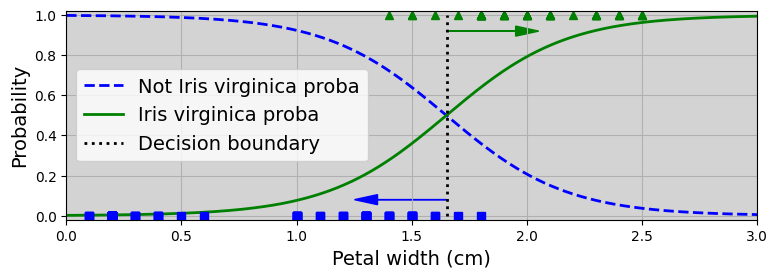

In [292]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies and saves Figure 4–23
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.gca().set_facecolor('lightgrey')
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
save_fig("logistic_regression_plot")

plt.show()

In [293]:
decision_boundary

1.6516516516516517

In [294]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

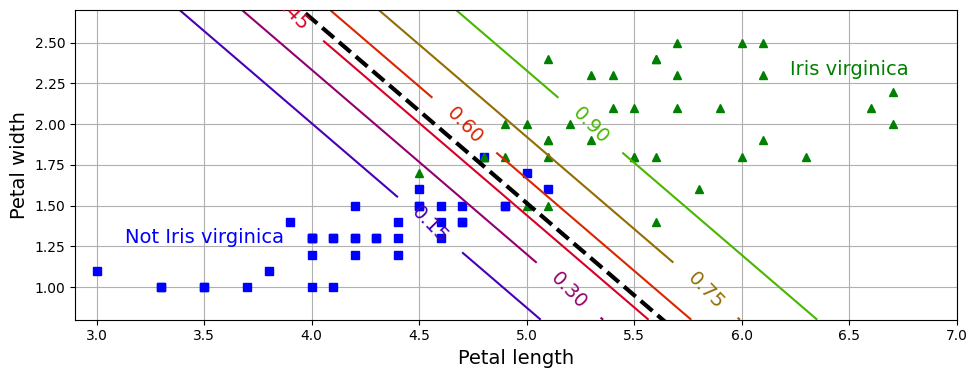

In [295]:
# extra code – this cell generates and saves Figure 4–24

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
save_fig("logistic_regression_contour_plot")
plt.show()

The graph illustrates a logistic regression model predicting whether an iris flower is of the species "Iris virginica" based on petal length and width. The decision boundary (black dashed line) separates the two classes: Iris virginica (green triangles) and not Iris virginica (blue squares). The colored lines represent different probability contours (e.g., 0.45, 0.60, 0.75, 0.90) for being Iris virginica, indicating the model's confidence levels. Points further from the decision boundary towards either class have higher predicted probabilities for their respective classes.

## Softmax Regression

The logistic regression model can be generalized to **support multiple classes directly**,without having to train and combine multiple binary classifiers. This is called softmax regression, or multinomial logistic regression.

In [296]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [297]:
softmax_reg.predict([[5, 2]])

array([2])

In [298]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

The code trains a softmax regression model to classify iris species using petal length and width. It predicts the species for a flower with petal length 5 cm and petal width 2 cm as class 2 (Iris virginica), with predicted probabilities of 0% for Iris setosa, 4% for Iris versicolor, and 96% for Iris virginica.

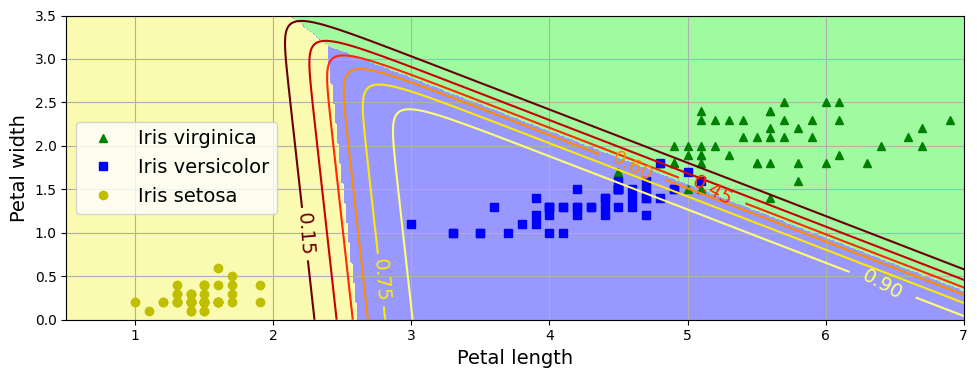

In [299]:
# extra code – this cell generates and saves Figure 4–25

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()

The graph depicts a logistic regression model classifying iris flower species based on petal length and width. The regions colored in yellow, purple, and green represent the predicted classes: Iris setosa (yellow circles), Iris versicolor (blue squares), and Iris virginica (green triangles). The contour lines indicate different probability levels for belonging to the Iris virginica class, with higher probabilities towards the top-right region. This visualization highlights the model's decision boundaries and confidence in its classifications.

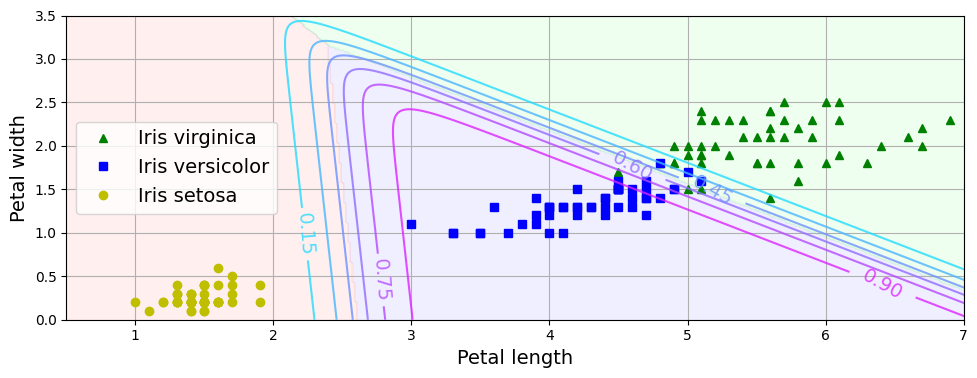

In [300]:
from matplotlib.colors import ListedColormap
alternative_cmap = ListedColormap(["#FFCCCC", "#CCCCFF", "#CCFFCC"])
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)
# Plot the data points and decision regions
plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")
plt.contourf(x0, x1, zz, cmap=alternative_cmap, alpha=0.3)
contour = plt.contour(x0, x1, zz1, cmap="cool", alpha=0.8)
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("alternative_softmax_regression_contour_plot")
plt.show()
